In [3]:
import pyscf
import matplotlib.pyplot as plt
from rdkit.Chem import MolFromSmiles, AddHs, AllChem
from scipy.optimize import minimize
from scipy.special import erfc, erf
import numpy as np

In [4]:
from typing import Any
class PGF:
    def __init__(self, alpha, coeff=1, R=np.zeros(3)) -> None:
        self.alpha = alpha  #定义alpha为Gaussian指数
        self.coeff = coeff 
        self.R = R # 中心定点
        self.N = np.power((2 * self.alpha / np.pi), 0.75) # N部分

    def __call__(self, r) -> Any:
        dr = r - self.R
        return self.N * self.coeff * np.exp(-self.alpha * np.dot(dr,dr))
    
    def __str__(self) -> str:
        return f"{self.coeff} * phi(alpha={self.alpha}, R={self.R})" 
    
    def __mul__(self,other):
        a = self.alpha
        b = other.alpha 
        RA = self.R
        RB = other.R     
        dR = RB-RA
        p = a + b 
        K = np.power(2 * a * b / ((a + b) * np.pi), 0.75) * np.exp(- a * b / (a + b) * np.dot(dR, dR))
        RP = (a * RA + b * RB) / (a + b)  
        print(f'coeff = {K} third_center = {RP} Gaussian_index = {p} ') 
        return PGF(alpha=p, coeff=K, R=RP)

In [5]:
s1 = PGF(1) # a=1 coeff=1 R
print(s1)
print(s1(np.array([0, 0, 0])))
print(s1(np.array([1, 1, 1])))
print(PGF(alpha=1, R = np.array([0, 0, 0])) * PGF(alpha=1, R = np.array([1, 1, 1])))
print(PGF(alpha=np.array([1,2,3]), coeff=np.array([1,2,3]))(np.zeros(3)))

1 * phi(alpha=1, R=[0. 0. 0.])
0.7127054703549902
0.035483515978714526
coeff = 0.09455747631590851 third_center = [0.5 0.5 0.5] Gaussian_index = 2 
0.09455747631590851 * phi(alpha=2, R=[0.5 0.5 0.5])
[0.71270547 2.3972459  4.87385145]


**收缩 Gaussian 函数（Contracted Gaussian Function, CGF）**。
$$\phi_\mu^\text{CGF}(\bm r-\bm R_\text A;\bm d_\mu,\bm\alpha_\mu)=\sum_{p=1}^Ld_{p\mu}\phi^\text{GF}(\bm r-\bm R_\text A;\alpha_{p\mu})$$

In [6]:
class CGF:
    def __init__(self, d, alpha, coeff=1, R=np.zeros(3)):
        self.d = d
        self.alpha = alpha
        self.coeff = coeff
        self.R = R

    def __call__(self,r):
        return np.sum(PGF(alpha=self.alpha, coeff=self.d, R=self.R)(r))

print(CGF(
  alpha=np.array([1,2,3]),
  d=np.array([1,2,3]),
  R=np.zeros(3)
)(np.zeros(3)))
    

7.9838028185813075


## Pople 风格基组通过拟合 STO 获得组合系数
氢原子的 STO-3G 基组只需要一个基函数代表其 1s 轨道，其形式为：
$$\phi^\text{STO-3G}_\text{1s}(\bm r;\bm d,\bm \alpha)=d_1\phi_\text{1s}^\text{GF}(\bm r;\alpha_1)+d_2\phi_\text{1s}^\text{GF}(\bm r;\alpha_2)+d_3\phi_\text{1s}^\text{GF}(\bm r;\alpha_3)$$

In [7]:
def sf_overlap_sto_3g(x):
    d = x[:3]
    alpha = x[3:]
    return -np.sum(d / (np.power(2 * np.pi, 1/4) * np.power(alpha, 7/4)) * (np.sqrt(np.pi) * np.exp(1 / (4 * alpha)) * (2 * alpha + 1) * erfc(1 / (2 * np.sqrt(alpha))) - 2 * np.sqrt(alpha)))

def norm_sto_3g_cond(x):
    d = x[:3]
    alpha = x[3:]
    return 4 * np.sqrt(2) * (
    d[0] * d[1] * (alpha[0] * alpha[1] / (alpha[0] + alpha[1]) ** 2) ** (3/4) +
    d[1] * d[2] * (alpha[1] * alpha[2] / (alpha[1] + alpha[2]) ** 2) ** (3/4) +
    d[0] * d[2] * (alpha[0] * alpha[2] / (alpha[0] + alpha[2]) ** 2) ** (3/4)
    ) + np.dot(d,d) - 1

In [8]:
opt = minimize(sf_overlap_sto_3g , x0=np.array([1/3,1/3,1/3,1,0.4,0.1]), constraints=(
    {'type': 'eq', 'fun': norm_sto_3g_cond}, 
    {'type': 'ineq', 'fun': lambda x: x[:3]}), options={'disp': True}, tol=1e-12) 

d1, alpha1 = opt.x[:3], opt.x[3:]
S = -opt.fun
print(print(f'{S}'))
print(f"d: {d1}, alpha:{alpha1}")

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.9998347362521997
            Iterations: 48
            Function evaluations: 365
            Gradient evaluations: 48
0.9998347362521997
None
d: [0.15432908 0.5353288  0.44463377], alpha:[2.2276601  0.40577062 0.1098174 ]


In [9]:
param_pyscf = pyscf.gto.basis.load('STO-3G', 'H')
print(len(param_pyscf))
print(param_pyscf)

d_pyscf = np.array(param_pyscf[0][1:])[:,1]
print(np.allclose(sorted(d1), sorted(d_pyscf)))

1
[[0, [3.42525091, 0.15432897], [0.62391373, 0.53532814], [0.1688554, 0.44463454]]]
True


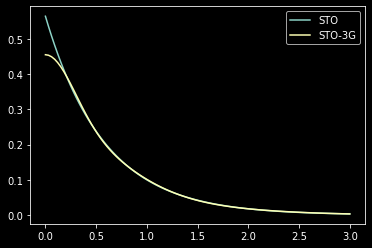

In [10]:
def sto(r):
    return np.power((1 / np.pi ), 1/2 ) * np.exp(-np.linalg.norm(r))

X = np.linspace(0,3,num=100)
sto_3g = CGF(d=d1, alpha=alpha1)
x_axis = X # r 
y1_axis_sto = np.array([sto(x * np.ones(3)) for x in X])
y2_axis_sto3g = np.array([sto_3g(x * np.ones(3)) for x in X])
plt.figure
plt.plot(x_axis, y1_axis_sto, label="STO")
plt.plot(x_axis, y2_axis_sto3g, label="STO-3G")
plt.legend()

一般情况下认为分子中的氢原子的波函数比独立的氢原子更加弥散，因此 STO-3G 基组实际上选择了 $\zeta=1.24\ne 1$ 的 STO 作为拟合目标。这可以从 $\zeta=1$ 的拟合结果通过坐标变换直接换算而来： $\alpha'=\alpha(\zeta'/\zeta)^2$，于是氢原子真正的 STO-3G 基组的轨道指数要在以上的 $\alpha$ 上乘 $1.24^2=1.5376$ 倍，得到以下数值。

In [11]:
alpha_pyscf = np.array(pyscf.gto.basis.load("sto-3g", "H")[0][1:])[:,0]
print (type(alpha_pyscf))
print(alpha_pyscf)
print(np.allclose(sorted(alpha1 * 1.24 ** 2), sorted(alpha_pyscf)))

<class 'numpy.ndarray'>
[3.42525091 0.62391373 0.1688554 ]
True


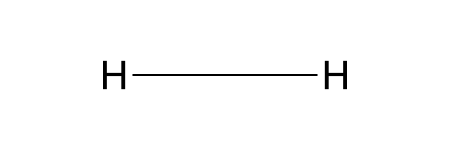

In [12]:
mol = MolFromSmiles('[H][H]')
mol = AddHs(mol) 
AllChem.EmbedMultipleConfs(mol, numConfs=1) #赋予1个构象
AllChem.MMFFOptimizeMolecule(mol) #力场优化
mol

由于 `rdkit` 的默认单位是 $\text{\AA}$，要将其转换到原子单位制，需要除以玻尔半径 $a_0=0.52918\,\text{\AA}$。然后方可用原子单位制下的坐标构建两个 STO-3G 基函数。

In [13]:
def STO_3G(R):
    R1 = R
    return CGF(d=d_pyscf, alpha=alpha_pyscf, R=R1)

In [14]:
a0 = 0.52918
conformer = mol.GetConformer(id=0) #取赋予的构象中的第一个
R_A_raw, R_B_raw = conformer.GetPositions()  #取构象坐标
print(R_A_raw, R_B_raw)
R_A, R_B =  R_A_raw / a0, R_B_raw / a0
print(R_A, R_B)
phi_A, phi_B = STO_3G(R_A), STO_3G(R_B)
print(phi_A, phi_B)
print(type(R_B_raw))

[0.34900944 0.         0.        ] [-0.34900944  0.          0.        ]
[0.65952878 0.         0.        ] [-0.65952878  0.          0.        ]
<__main__.CGF object at 0x7f5e5806b3a0> <__main__.CGF object at 0x7f5e5806b400>
<class 'numpy.ndarray'>


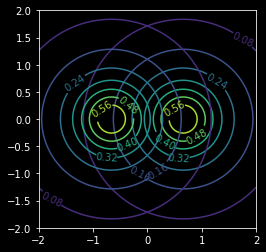

In [15]:
def orbital_contour(*phis):
    x = np.linspace(-2, 2, 100)
    y = np.linspace(-2, 2, 100)
    X, Y = np.meshgrid(x, y) #grid
    plt.figure()
    ax = plt.gca()
    ax.set_aspect(1)
    for phi in phis: #phi是来自phis的函数 phis是输入的phi_A and phi_B
        Z = np.array([[phi(np.array([X[i][j], Y[i][j], 0])) for j in range(100)] for i in range(100)]) # i 和 j 的迭代顺序决定了先输出图的取向
        contour_line = plt.contour(X, Y, Z)
        plt.clabel(contour_line, inline=True)
    plt.show()

orbital_contour(phi_A, phi_B)